# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a "specialized agent" for each task or domain and route tasks to the correct "expert". This means that each agent can become a sequence of LLM calls that chooses how to use a specific "tool".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using Burr.


In [1]:
# %pip install -U burr[start] langchain-community langchain-core langchain-experimental openai

In [2]:
# Environment variables
import os
# Make sure TAVILY_API_KEY & OPENAI_API_KEY are set
# os.environ['TAVILY_API_KEY'] = 'your_tavily_api_key' # get one at https://tavily.com
# os.environ['OPENAI_API_KEY'] = 'your_openai_api_key' # get one at https://platform.openai.com

In [26]:
# import everything that you'll need
import pprint
import json
from typing import Annotated, Any, Optional
from uuid import UUID

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.callbacks import BaseCallbackHandler
from langchain_core.messages import FunctionMessage, HumanMessage
from langchain_core.outputs import LLMResult
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

from burr import core
from burr.core import Action, State, action, default, expr
from burr.lifecycle import PostRunStepHook
from burr.tracking import client as burr_tclient
from burr.visibility import ActionSpanTracer, TracerFactory

 # Define the tools that the agents will use

Here we construct the python objects that will be used as tools by our code.

In [2]:
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        # Warning: This executes code locally, which can be unsafe when not sandboxed
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)

# Define the agents
Our "agents" are effectively an execution of a series of LLM calls. 
In this example we use LCEL to orchestrate this series of LLM calls.

Unfortunately LangChain & LCEL don't give you an easy way to figure out all the prompts used, etc.

In [13]:
# The Agent that we'll use. Our agents here only differ by the system message passed in.
def create_agent(llm, tools, system_message: str):
    """Helper function to create an agent with a system message and tools."""
    functions = [convert_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

def _exercise_agent(messages: list, sender: str, agent, name: str) -> dict:
    """Helper function to exercise the agent code."""
    result = agent.invoke({"messages": messages, "sender": sender})
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": result,
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

# Define the actual agents via langchain's LCEL
llm = ChatOpenAI(model="gpt-4-1106-preview")
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)

# Define the actions that map to agents
We now then create specific actions that map to the agents we need for this not example.
    
We want a "chart generator" action, that will map to an agent that can generate a chart based on provided context/data.

We want a "researcher" action, that will map to an agent that can search for information on a topic.

We then want a "tool_node" action, that will run a tool as specified by the prior action, i.e. agent.

In [14]:
@action(reads=["messages", "sender"], writes=["messages", "sender"])
def research_node(state: State) -> tuple[dict, State]:
    # Research agent and node
    result = _exercise_agent(state["messages"], state["sender"], research_agent, "Researcher")
    return result, state.append(messages=result["messages"]).update(sender="Researcher")


@action(reads=["messages", "sender"], writes=["messages", "sender"])
def chart_node(state: State) -> tuple[dict, State]:
    # Chart agent and node
    result = _exercise_agent(
        state["messages"], state["sender"], chart_agent, "Chart Generator"
    )
    return result, state.append(messages=result["messages"]).update(sender="Chart Generator")


@action(reads=["messages"], writes=["messages"])
def tool_node(state: State) -> tuple[dict, State]:
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(last_message.additional_kwargs["function_call"]["arguments"])
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}, state.append(messages=function_message)


@action(reads=[], writes=[])
def terminal_step(state: State) -> tuple[dict, State]:
    """Terminal step we have here that does nothing, but it could"""
    return {}, state

# Define the Graph / Application
With Burr we need to now construct our application, i.e. graph, by:

1. Defining what the actions are and how to transition between them.
2. Defining the initial state of the application. In our example this means we need to provide a "query" for the agents to work on.

Because Burr comes with built in persistence, we can also load a prior execution and continue from 
any point in its history by specifying a `app_instance_id` and `sequence_number` when building the application.

In [15]:
# Adjust these if you want to load a prior execution
app_instance_id = None
sequence_id = None
project_name = "demo:lcel-multi-agent"

# CHANGE THIS IF YOU WANT SOMETHING DIFFERENT!
default_query = ("Fetch the UK's GDP over the past 5 years, then draw a line graph of it. "
                 "Once the python code has been written and the graph drawn, the task is complete.")

In [16]:
# Determine initial state and entry point
def default_state_and_entry_point(query: str = None) -> tuple[dict, str]:
    """Sets the default state & entry point
    :param query: the query for the agents to work on.
    :return:
    """
    return (
        dict(
            messages=[
                HumanMessage(
                    content=query
                )
            ],
            sender=None,
        ),
        "researcher",
    )

if app_instance_id:
    tracker = burr_tclient.LocalTrackingClient(project_name)
    persisted_state = tracker.load("demo", app_id=app_instance_id, sequence_no=sequence_id)
    if not persisted_state:
        print(f"Warning: No persisted state found for app_id {app_instance_id}.")
        initial_state, entry_point = default_state_and_entry_point(default_query)
    else:
        initial_state = persisted_state["state"]
        # for now we need to manually deserialize LangChain messages into LangChain Objects
        from langchain_core import messages

        initial_state = initial_state.update(
            messages=messages.messages_from_dict(persisted_state["state"]["messages"])
        )
        entry_point = persisted_state["position"]
else:
    initial_state, entry_point = default_state_and_entry_point(default_query)

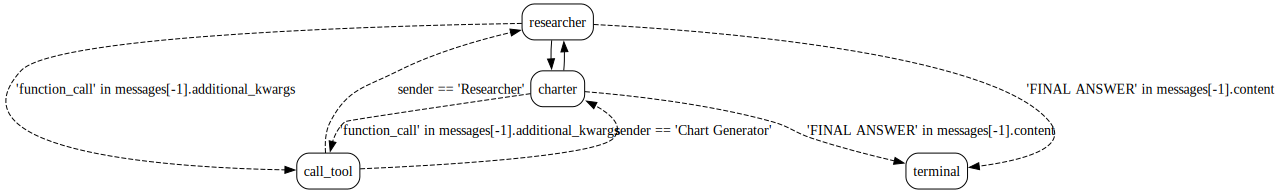

In [17]:
# Build the application 
def build_application(state: dict, entry_point: str):
    _app = (
        core.ApplicationBuilder()
        .with_state(**state)
        .with_actions(
            researcher=research_node,
            charter=chart_node,
            call_tool=tool_node,
            terminal=terminal_step,
        )
        .with_transitions(
            ("researcher", "call_tool", expr("'function_call' in messages[-1].additional_kwargs")),
            ("researcher", "terminal", expr("'FINAL ANSWER' in messages[-1].content")),
            ("researcher", "charter", default),
            ("charter", "call_tool", expr("'function_call' in messages[-1].additional_kwargs")),
            ("charter", "terminal", expr("'FINAL ANSWER' in messages[-1].content")),
            ("charter", "researcher", default),
            ("call_tool", "researcher", expr("sender == 'Researcher'")),
            ("call_tool", "charter", expr("sender == 'Chart Generator'")),
        )
        .with_entrypoint(entry_point)
        .with_tracker(project=project_name)
        .build()
    )
    return _app
app = build_application(initial_state, entry_point)
app.visualize(
    output_file_path="statemachine", include_conditions=True, format="png"
)

# open up the Burr UI to trace the execution
In another terminal run:
```bash
burr
```
and then open up the browser to [http://localhost:7241](http://localhost:7241) to see the execution of the application when you exercise `.run()` below.

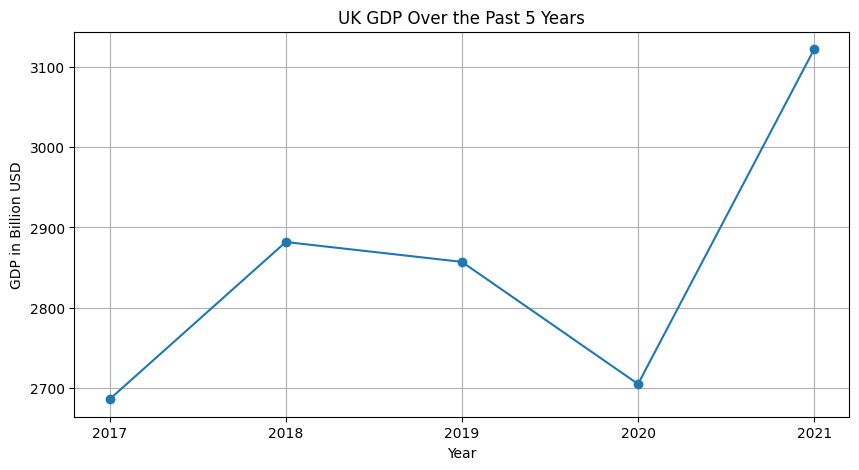

In [22]:
# this will run until completion.
last_action, last_result, last_state = app2.run(halt_after=["terminal"])

In [ ]:
pprint.pprint(last_state)

# Change the Query!
Right now we provide the starting query as state. So we just create a new application by adjusting 
the initial state we provide.

In [23]:
# Let's change the query
initial_state, entry_point = default_state_and_entry_point("Fetch the USA's GDP over the past 5 years, then draw a line graph of it. "
                 "Once the python code has been written and the graph drawn, the task is complete.")
app2 = build_application(initial_state, entry_point)

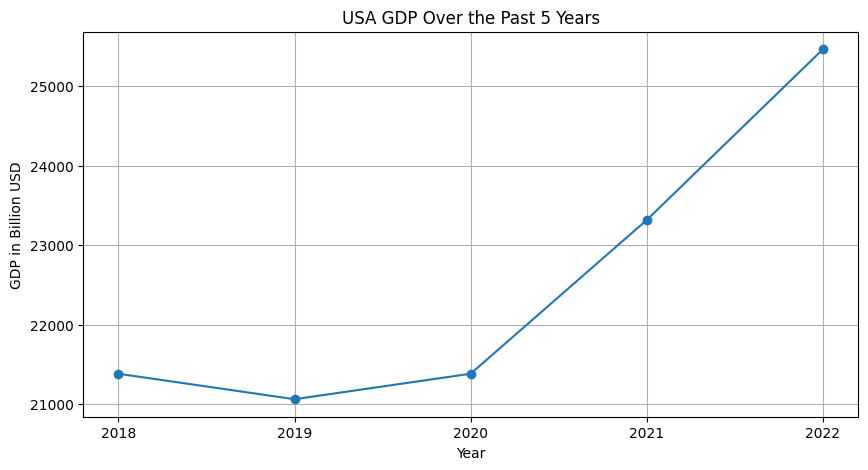

In [27]:
# this will run until completion.
last_action, last_result, last_state = app2.run(halt_after=["terminal"])

In [28]:
pprint.pprint(last_state)

{'messages': [HumanMessage(content="Fetch the USA's GDP over the past 5 years, then draw a line graph of it. Once the python code has been written and the graph drawn, the task is complete."), HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"USA GDP by year for the past 5 years"}', 'name': 'tavily_search_results_json'}}, name='Researcher'), FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://usafacts.org/data/topics/economy/economic-indicators/gdp/gross-domestic-product/\', \'content\': \'Data Adjustments\\nIs the economy growing?\\nRelated Metrics\\nAnnual percent change in real GDP\\n5.7%\\n2021\\nAnnual percent change in real GDP\\n5.7%\\n2021\\nExplore Gross domestic product\\nInteract with the data\\nData Adjustments\\nState Display\\nOur nation, in numbers\\nUSAFacts is a not-for-profit, nonpartisan civic initiative making government data easy for all Americans to access and understand.\\n • Check your spelling\\